In [1]:
import pandas as pd
import numpy as np
from scipy.interpolate import CubicSpline
import os

# 설정
DATA_ROOT = "C:/Capstone_design/project/data/Sensor"
PARTICIPANTS = [f"P{i}" for i in range(10, 20)]
FEATURE_FILES = {
    "HR.csv": "bpm",
    "RRI.csv": "interval",
    "EDA.csv": "resistance",
    "SkinTemperature.csv": "skin_temperature"
}

for pid in PARTICIPANTS:
    participant_path = os.path.join(DATA_ROOT, pid)
    dfs = []

    for file_name, col_name in FEATURE_FILES.items():
        file_path = os.path.join(participant_path, file_name)
        if not os.path.exists(file_path):
            continue

        df = pd.read_csv(file_path)
        if 'timestamp' not in df.columns:
            continue

        df = df.rename(columns={df.columns[1]: col_name})
        df['datetime_kst'] = pd.to_datetime(df['timestamp'], unit='ms', utc=True).dt.tz_convert("Asia/Seoul")
        df = df[['datetime_kst', col_name]].dropna()
        dfs.append(df.set_index('datetime_kst'))

    # 병합 및 보간
    if dfs:
        merged_df = pd.concat(dfs, axis=1).sort_index()

        if 'interval' in merged_df.columns:
            interval_series = merged_df['interval'].dropna()
            if len(interval_series) >= 4:
                ts = interval_series.index.view(np.int64) // 10**6
                cs = CubicSpline(ts, interval_series.values)
                full_ts = merged_df.index.view(np.int64) // 10**6
                merged_df['interval'] = cs(full_ts)

        for col in ['bpm', 'resistance', 'skin_temperature']:
            if col in merged_df.columns:
                merged_df[col] = merged_df[col].interpolate(method='linear', limit_direction='both')

        merged_df.reset_index().to_csv(os.path.join(participant_path, f"merged_df_{pid}.csv"), index=False)
        print(f"[✔] Saved: {pid}/merged_df_{pid}.csv")
    else:
        print(f"[⚠] No valid data for {pid}")

[✔] Saved: P10/merged_df_P10.csv
[✔] Saved: P11/merged_df_P11.csv
[✔] Saved: P12/merged_df_P12.csv
[✔] Saved: P13/merged_df_P13.csv
[✔] Saved: P14/merged_df_P14.csv
[✔] Saved: P15/merged_df_P15.csv
[✔] Saved: P16/merged_df_P16.csv
[✔] Saved: P17/merged_df_P17.csv
[✔] Saved: P18/merged_df_P18.csv
[✔] Saved: P19/merged_df_P19.csv


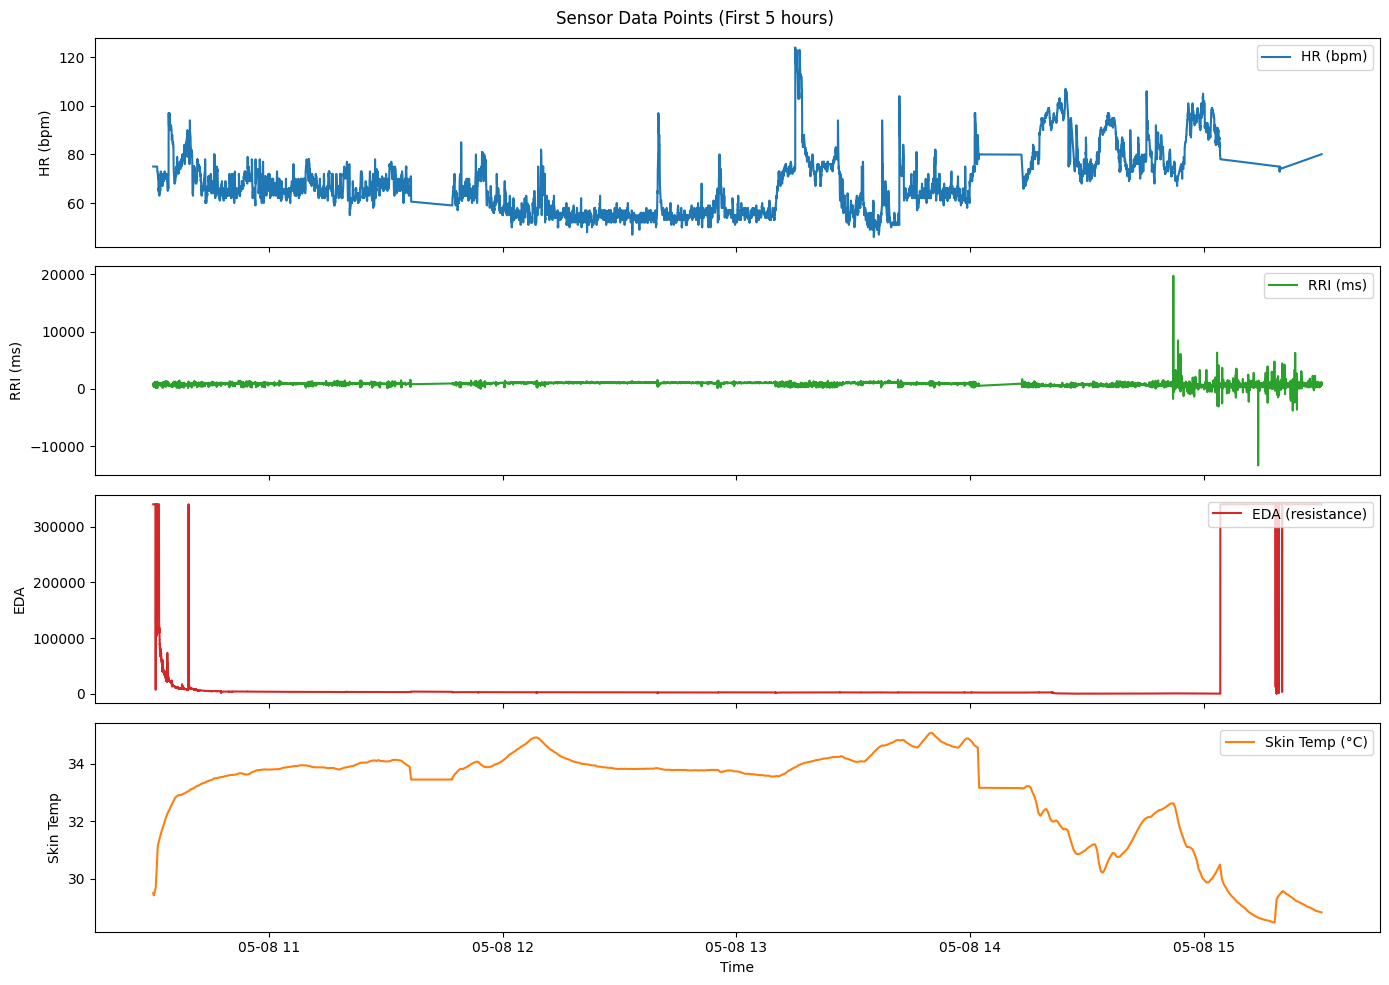

In [2]:
import matplotlib.pyplot as plt

df = pd.read_csv("C:/Capstone_design/project/data/Sensor/P10/merged_df_P10.csv")

# 특정 기간을 시각화 (처음 10분)
df['datetime_kst'] = pd.to_datetime(df['datetime_kst'], format='mixed')
start_time = df['datetime_kst'].min()
end_time = start_time + pd.Timedelta(minutes=300)
df_subset = df[(df['datetime_kst'] >= start_time) & (df['datetime_kst'] <= end_time)]

# 시각화: 네 feature를 한 Figure에 겹치지 않게 나눠 그림
fig, axs = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

axs[0].plot(df_subset['datetime_kst'], df_subset['bpm'], label='HR (bpm)', color='tab:blue')
axs[0].set_ylabel('HR (bpm)')
axs[0].legend(loc='upper right')

axs[1].plot(df_subset['datetime_kst'], df_subset['interval'], label='RRI (ms)', color='tab:green')
axs[1].set_ylabel('RRI (ms)')
axs[1].legend(loc='upper right')

axs[2].plot(df_subset['datetime_kst'], df_subset['resistance'], label='EDA (resistance)', color='tab:red')
axs[2].set_ylabel('EDA')
axs[2].legend(loc='upper right')

axs[3].plot(df_subset['datetime_kst'], df_subset['skin_temperature'], label='Skin Temp (°C)', color='tab:orange')
axs[3].set_ylabel('Skin Temp')
axs[3].legend(loc='upper right')

plt.xlabel('Time')
plt.suptitle("Sensor Data Points (First 5 hours)")
plt.tight_layout()
plt.show()


In [3]:

# 리샘플링 적용 후 코드 => 공통 시간축 : '1s'

import pandas as pd
import numpy as np
from scipy.interpolate import CubicSpline
import os

# 설정
DATA_ROOT = "C:/Capstone_design/project/data/Sensor"
PARTICIPANTS = [f"P{i}" for i in range(10, 15)]
FEATURE_FILES = {
    "HR.csv": "bpm",
    "RRI.csv": "interval",
    "EDA.csv": "resistance",
    "SkinTemperature.csv": "skin_temperature"
}
TARGET_FREQ = '1s'  # 공통 시간 간격 (1초)

for pid in PARTICIPANTS:
    participant_path = os.path.join(DATA_ROOT, pid)
    dfs = []

    for file_name, col_name in FEATURE_FILES.items():
        file_path = os.path.join(participant_path, file_name)
        if not os.path.exists(file_path):
            continue

        df = pd.read_csv(file_path)
        if 'timestamp' not in df.columns:
            continue

        # 컬럼 정리 및 시간 변환
        df.columns = ['timestamp', col_name]  # 첫 번째는 timestamp, 두 번째는 값
        df['datetime_kst'] = pd.to_datetime(df['timestamp'], unit='ms', utc=True).dt.tz_convert("Asia/Seoul")
        df = df[['datetime_kst', col_name]].dropna().set_index('datetime_kst')
        dfs.append(df)

    # 병합
    if dfs:
        merged_df = pd.concat(dfs, axis=1).sort_index()
        
        # 공통 시간축 생성 및 리샘플링
        common_index = pd.date_range(
            start=merged_df.index.min(),
            end=merged_df.index.max(),
            freq=TARGET_FREQ,
            tz='Asia/Seoul'
        )
        merged_df = merged_df.reindex(common_index)

        # interval 보간: cubic spline
        if 'interval' in merged_df.columns:
            interval_series = merged_df['interval'].dropna()
            if len(interval_series) >= 4:
                try:
                    ts_ms = interval_series.index.view(np.int64) // 10**6
                    cs = CubicSpline(ts_ms, interval_series.values)
                    full_ts = merged_df.index.view(np.int64) // 10**6
                    merged_df['interval'] = cs(full_ts)
                except Exception as e:
                    print(f"[!] Spline error for {pid}: {e}")

        # 나머지 필드 선형 보간
        for col in ['bpm', 'resistance', 'skin_temperature']:
            if col in merged_df.columns:
                merged_df[col] = merged_df[col].interpolate(method='linear', limit_direction='both')

        # 저장
        output_path = os.path.join(participant_path, f"merged_df_{pid}.csv")
        merged_df.reset_index(names='datetime_kst').to_csv(output_path, index=False)
        print(f"[✔] Saved: {output_path}")
    else:
        print(f"[⚠] No valid data for {pid}")


C:\Users\leejo\AppData\Local\Temp\ipykernel_11920\3321824626.py:41: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  common_index = pd.date_range(


[✔] Saved: C:/Capstone_design/project/data/Sensor\P10\merged_df_P10.csv


C:\Users\leejo\AppData\Local\Temp\ipykernel_11920\3321824626.py:41: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  common_index = pd.date_range(


[✔] Saved: C:/Capstone_design/project/data/Sensor\P11\merged_df_P11.csv


C:\Users\leejo\AppData\Local\Temp\ipykernel_11920\3321824626.py:41: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  common_index = pd.date_range(


[✔] Saved: C:/Capstone_design/project/data/Sensor\P12\merged_df_P12.csv


C:\Users\leejo\AppData\Local\Temp\ipykernel_11920\3321824626.py:41: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  common_index = pd.date_range(


[✔] Saved: C:/Capstone_design/project/data/Sensor\P13\merged_df_P13.csv


C:\Users\leejo\AppData\Local\Temp\ipykernel_11920\3321824626.py:41: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  common_index = pd.date_range(


[✔] Saved: C:/Capstone_design/project/data/Sensor\P14\merged_df_P14.csv


In [ ]:
import pandas as pd
import numpy as np
from scipy.interpolate import CubicSpline
import os

# 설정
DATA_ROOT = "C:/Capstone_design/project/data/Sensor"
PARTICIPANTS = [f"P{i}" for i in range(16, 17)]

FEATURE_FILES = {
    "HR.csv": "bpm",
    "RRI.csv": "interval",
    "EDA.csv": "resistance",
    "SkinTemperature.csv": "skin_temperature"
}

# 센서별 리샘플링 주기 설정
RESAMPLE_FREQS = {
    "bpm": "1s",             # HR : 1s
    "interval": "1s",        # RRI : 1s
    "resistance": "500ms",   # EDA : 500ms, EDA 주기에 맞게 다른 데이터들도 리샘플링됨.
    "skin_temperature": "1s" # Skin Temp : 1s   
}

for pid in PARTICIPANTS:
    participant_path = os.path.join(DATA_ROOT, pid)
    sensor_dfs = {}

    for file_name, col_name in FEATURE_FILES.items():
        file_path = os.path.join(participant_path, file_name)
        if not os.path.exists(file_path):
            continue

        df = pd.read_csv(file_path)
        if 'timestamp' not in df.columns:
            continue

        df.columns = ['timestamp', col_name]
        df['datetime_kst'] = pd.to_datetime(df['timestamp'], unit='ms', utc=True).dt.tz_convert("Asia/Seoul")
        df = df[['datetime_kst', col_name]].dropna().set_index('datetime_kst')

        # 리샘플링
        freq = RESAMPLE_FREQS[col_name]
        df = df.resample(freq).mean()

        sensor_dfs[col_name] = df

    # 병합
    if sensor_dfs:
        # 공통 시간 범위 계산
        start = max(df.index.min() for df in sensor_dfs.values())
        end = min(df.index.max() for df in sensor_dfs.values())
        if start >= end:
            print(f"[⚠] No overlap in time for {pid}")
            continue

        # 시간 인덱스: 가장 촘촘한 센서 기준 (500ms)
        merged_index = pd.date_range(start=start, end=end, freq="500ms", tz='Asia/Seoul')
        merged_df = pd.DataFrame(index=merged_index)

        for col_name, df in sensor_dfs.items():
            merged_df = merged_df.join(df, how='left')

        # CubicSpline for RRI
        if 'interval' in merged_df.columns:
            interval_series = merged_df['interval'].dropna()
            if len(interval_series) >= 4:
                print("보간이 필요합니다")
                try:
                    ts_ms = interval_series.index.view(np.int64) // 10**6
                    cs = CubicSpline(ts_ms, interval_series.values)
                    full_ts = merged_df.index.view(np.int64) // 10**6
                    merged_df['interval'] = cs(full_ts)
                except Exception as e:
                    print(f"[!] Spline error for {pid}: {e}")

        # 나머지 보간
        for col in ['bpm', 'resistance', 'temperature']:
            if col in merged_df.columns:
                merged_df[col] = merged_df[col].interpolate(method='linear', limit_direction='both')

        # 저장 (datetime_kst + 센서 컬럼들)
        output_path = os.path.join(participant_path, f"merged_df_{pid}.csv")
        merged_df.reset_index(names='datetime_kst').to_csv(output_path, index=False)
        print(f"[✔] Saved: {output_path}")
    else:
        print(f"[⚠] No valid data for {pid}")


보간이 필요합니다
[✔] Saved: C:/Capstone_design/project/data/Sensor\P16\merged_df_P16.csv
